### Preprocess Text Data and Modelling 
### ANLY 590 Project


***

#### Prep

In [180]:
# set working directory
import os
import sys
path = '/Users/kgedney/Documents/georgetown/anly590/author-id-project'
os.chdir(path)

In [181]:
import numpy as np
import pandas as pd

In [182]:
# load filtered data
df = pd.read_csv('filtered_data.csv')

#### Google Colab Prep

In [9]:
# get data from Google drive
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [162]:
# manually add file from local to drive
df = pd.read_csv('filtered_data.csv')
df.head()

,author,body,subreddit,permalink,num_chars,num_words
0,GuaranteedAdmission,News aggregators don't filter Opinion pieces i...,AskAnAmerican,/r/AskAnAmerican/comments/9zrnid/america_whats...,69,11
1,GuaranteedAdmission,You can be in favor of a policy he supports an...,AskReddit,/r/AskReddit/comments/9zklcs/as_a_brit_who_onl...,74,17
2,GuaranteedAdmission,That depends. What is the penalty for breaking...,AskReddit,/r/AskReddit/comments/9zkfcd/how_would_you_fee...,202,36
3,GuaranteedAdmission,Because I like to think long term. Tax cuts fo...,AskReddit,/r/AskReddit/comments/9yxl98/liberals_of_reddi...,120,22
4,GuaranteedAdmission,"We don't talk about the Highway Shoes, OP! Are...",AskReddit,/r/AskReddit/comments/9yrbvd/people_who_lost_a...,110,22


In [ ]:
# download nltk
import nltk
nltk.download('popular')

#### Text Cleaning

ref: https://www.analyticsvidhya.com/blog/2018/02/the-different-methods-deal-text-data-predictive-python/

In [184]:
# remove URLs and replace as '<url>'
import re
df['body_no_urls'] = df.apply(lambda row: re.sub(r"http\S+", "<url>", row['body']), axis=1) 

In [185]:
# tokenize
from nltk.tokenize import word_tokenize
df['tokenized_nltk']  = df.apply(lambda row: word_tokenize(row['body_no_urls']), axis=1)

In [0]:
# remove NERs

In [0]:
# import spacy
# nlp = spacy.load('en')

In [0]:
# def get_ners(input_doc):
#     doc = nlp(input_doc)
#     ners = str(doc.ents)
#     return (ners)

***

#### Modelling

In [189]:
# install packages
import numpy as np

from sklearn import metrics
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer

import keras
import tensorflow as tf

from keras.utils import np_utils
from keras.preprocessing import sequence
from keras.preprocessing.text import Tokenizer

from keras.models import Model, Sequential
from keras.layers import Input, Dense, CuDNNLSTM, LSTM, Embedding, Bidirectional, GlobalAveragePooling1D

from keras.layers.core import Dense, Dropout

In [190]:
# create class assignments
df['author_id'] = pd.Categorical(df.author).codes

#### Baseline Model: Linear SVM

In [0]:
x = df['body_no_urls'].values
y = df['author_id'].values

x_train, x_test, y_train, y_test = train_test_split(x, y, test_size=0.20, random_state=22)

tfidf_vec   = TfidfVectorizer()
x_train_vec = tfidf_vec.fit_transform(x_train)
x_test_vec  = tfidf_vec.transform(x_test)
x_train_vec.shape

/Users/kgedney/anaconda/lib/python3.6/site-packages/sklearn/feature_extraction/text.py:1059: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  if hasattr(X, 'dtype') and np.issubdtype(X.dtype, np.float):


(58129, 53161)

In [0]:
from sklearn.svm import LinearSVC
clf             = LinearSVC().fit(x_train_vec, y_train)
predicted       = clf.predict(x_test_vec)
predicted_score = clf.decision_function(x_test_vec)

In [0]:
print('accuracy', metrics.accuracy_score(y_test, predicted))

accuracy 0.37789857565540497


#### Preprocess Data for Keras Models

In [167]:
# data preprocess
x = df['tokenized_nltk'].values
y = df['author_id'].values

# create sequences
max_features = 25000
tokenizer    = Tokenizer(num_words = max_features)
tokenizer.fit_on_texts(x)
x_sequences  = tokenizer.texts_to_sequences(x)

# pad each sequence to be max length
maxlen = max(len(x) for x in x_sequences)
print(maxlen)
x_sequences = sequence.pad_sequences(x_sequences, maxlen)

236


In [0]:
# split test and train
x_train, x_test, y_train, y_test = train_test_split(x_sequences, y, test_size=0.20, random_state=22)

#### 0. Recurrent Nueral Network: LSTM

In [0]:
model = Sequential()

# add embedding layer
model.add(Embedding(input_dim=max_features,
                    output_dim=128,
                    mask_zero=True))
# add rnn layer
model.add(LSTM(128))
# model.add(Dropout(0.2))

# output layer, 100-categorical classification
model.add(Dense(100, activation="softmax"))

In [0]:
model.compile(optimizer="rmsprop", loss="sparse_categorical_crossentropy", metrics=["acc"])

In [0]:
model.fit(x_train, y_train,
            batch_size=128,
            epochs=1,
            validation_data=(x_test, y_test))

Train on 58129 samples, validate on 14533 samples
Epoch 1/1
 4608/58129 [=>............................] - ETA: 3:20 - loss: 4.6005 - acc: 0.0117

Exception ignored in: <bound method BaseSession._Callable.__del__ of <tensorflow.python.client.session.BaseSession._Callable object at 0x12af0d9b0>>
Traceback (most recent call last):
  File "/Users/kgedney/anaconda/lib/python3.6/site-packages/tensorflow/python/client/session.py", line 1408, in __del__
    def __del__(self):
KeyboardInterrupt


 5632/58129 [=>............................] - ETA: 3:18 - loss: 4.5987 - acc: 0.0133

KeyboardInterrupt: 

In [0]:
print('accuracy', model.evaluate(x_test, y_test)[1])

In [0]:
(y_train == 57).mean() # guess majority class baseline

0.012558275559531387

In [0]:
# keras.metrics.top_k_categorical_accuracy(y_test, predicted, k=5)

#### 1. Faster RNN Model: CuDNNLSTM 

- Run on Google Colab, 14 mins.    
- Very overfit

In [0]:
# ref: https://keras.io/layers/recurrent/#cudnnlstm
# faster LSTM implementation

model1 = Sequential()
model1.add(Embedding(input_dim=max_features,
                     output_dim=128))
model1.add(CuDNNLSTM(128))
model1.add(Dropout(0.5))
model1.add(Dense(100, activation="softmax"))

model1.compile(optimizer="adam", loss="sparse_categorical_crossentropy", metrics=["acc"])

In [170]:
history1 = model1.fit(x_train, y_train,
            batch_size=128,
            epochs=16,
            validation_data=(x_test, y_test))

Train on 58129 samples, validate on 14533 samples
Epoch 1/16
58129/58129 [==============================] - 31s 541us/step - loss: 4.3885 - acc: 0.0355 - val_loss: 4.1402 - val_acc: 0.0617
Epoch 2/16
58129/58129 [==============================] - 29s 499us/step - loss: 3.9996 - acc: 0.0799 - val_loss: 3.8960 - val_acc: 0.1011
Epoch 3/16
58129/58129 [==============================] - 29s 499us/step - loss: 3.6316 - acc: 0.1414 - val_loss: 3.7022 - val_acc: 0.1438
Epoch 4/16
58129/58129 [==============================] - 29s 503us/step - loss: 3.2425 - acc: 0.2188 - val_loss: 3.5500 - val_acc: 0.1838
Epoch 5/16
58129/58129 [==============================] - 29s 505us/step - loss: 2.8523 - acc: 0.3047 - val_loss: 3.5331 - val_acc: 0.2100
Epoch 6/16
58129/58129 [==============================] - 29s 501us/step - loss: 2.4923 - acc: 0.3857 - val_loss: 3.5573 - val_acc: 0.2233
Epoch 7/16
58129/58129 [==============================] - 29s 504us/step - loss: 2.1769 - acc: 0.4616 - val_loss: 3.

In [181]:
print('accuracy', model1.evaluate(x_test, y_test)[1])

14533/14533 [==============================] - 7s 484us/step
accuracy 0.24110644739558246


In [182]:
print('accuracy', model1.evaluate(x_train, y_train)[1])

58129/58129 [==============================] - 28s 481us/step
accuracy 0.9177690997639528


In [0]:
# save models #ref: https://medium.com/tensorflow/train-on-google-colab-and-run-on-the-browser-a-case-study-8a45f9b1474e


#### 2. Bidirectional

- Also overfits 

In [0]:
# Bidirectional
model2 = Sequential()
model2.add(Embedding(input_dim=max_features,
                     output_dim=128))

model2.add(Bidirectional(CuDNNLSTM(128)))
model2.add(Dropout(0.5))
model2.add(Dense(100, activation="softmax"))

model2.compile(optimizer="adam", loss="sparse_categorical_crossentropy", metrics=["acc"])

In [205]:
history2 = model2.fit(x_train, y_train,
            batch_size=128,
            epochs=16,
            validation_data=(x_test, y_test))

Train on 58129 samples, validate on 14533 samples
Epoch 1/16
58129/58129 [==============================] - 55s 944us/step - loss: 4.3900 - acc: 0.0376 - val_loss: 4.1689 - val_acc: 0.0581
Epoch 2/16
58129/58129 [==============================] - 53s 906us/step - loss: 4.0336 - acc: 0.0756 - val_loss: 3.9293 - val_acc: 0.0972
Epoch 3/16
58129/58129 [==============================] - 52s 897us/step - loss: 3.6746 - acc: 0.1363 - val_loss: 3.6980 - val_acc: 0.1485
Epoch 4/16
58129/58129 [==============================] - 52s 887us/step - loss: 3.2963 - acc: 0.2091 - val_loss: 3.5974 - val_acc: 0.1812
Epoch 5/16
58129/58129 [==============================] - 52s 889us/step - loss: 2.9070 - acc: 0.2940 - val_loss: 3.5326 - val_acc: 0.2072
Epoch 6/16
58129/58129 [==============================] - 52s 896us/step - loss: 2.5616 - acc: 0.3727 - val_loss: 3.5402 - val_acc: 0.2257
Epoch 7/16
58129/58129 [==============================] - 52s 893us/step - loss: 2.2489 - acc: 0.4428 - val_loss: 3.

In [206]:
print('accuracy', model2.evaluate(x_test, y_test)[1])

14533/14533 [==============================] - 13s 905us/step
accuracy 0.24378999518337577


#### 3. Averaging Word Embeddings: Very Simple Model/ Similar to FastText

In [0]:
#ref: https://github.com/keras-team/keras/blob/master/examples/imdb_fasttext.py

In [0]:
model3 = Sequential()
model3.add(Embedding(input_dim=max_features,
                    output_dim=128))

# we add a GlobalAveragePooling1D, which will average the embeddings
# of all words in the document
model3.add(GlobalAveragePooling1D())
model3.add(Dropout(0.5))

model3.add(Dense(100, activation="softmax"))

In [0]:
opt = keras.optimizers.Adam(lr=0.01) # speed up optimization
model3.compile(optimizer=opt, loss="sparse_categorical_crossentropy", metrics=["acc"])

In [233]:
history3 = model3.fit(x_train, y_train,
            batch_size=256,
            epochs=16,
            validation_data=(x_test, y_test))

Train on 58129 samples, validate on 14533 samples
Epoch 1/16
58129/58129 [==============================] - 6s 101us/step - loss: 4.4629 - acc: 0.0437 - val_loss: 4.2385 - val_acc: 0.0897
Epoch 2/16
58129/58129 [==============================] - 3s 51us/step - loss: 3.9853 - acc: 0.1360 - val_loss: 3.7689 - val_acc: 0.1910
Epoch 3/16
58129/58129 [==============================] - 3s 51us/step - loss: 3.5121 - acc: 0.2322 - val_loss: 3.4123 - val_acc: 0.2544
Epoch 4/16
58129/58129 [==============================] - 3s 52us/step - loss: 3.1155 - acc: 0.3150 - val_loss: 3.1577 - val_acc: 0.3095
Epoch 5/16
58129/58129 [==============================] - 3s 52us/step - loss: 2.7806 - acc: 0.3850 - val_loss: 2.9838 - val_acc: 0.3423
Epoch 6/16
58129/58129 [==============================] - 3s 52us/step - loss: 2.4962 - acc: 0.4494 - val_loss: 2.8611 - val_acc: 0.3621
Epoch 7/16
58129/58129 [==============================] - 3s 52us/step - loss: 2.2576 - acc: 0.5005 - val_loss: 2.7541 - val_ac

In [234]:
print('accuracy', model3.evaluate(x_test, y_test)[1])

14533/14533 [==============================] - 1s 73us/step
accuracy 0.41870226381441555


#### Plots + Compare Models

In [0]:
import matplotlib.pyplot as plt

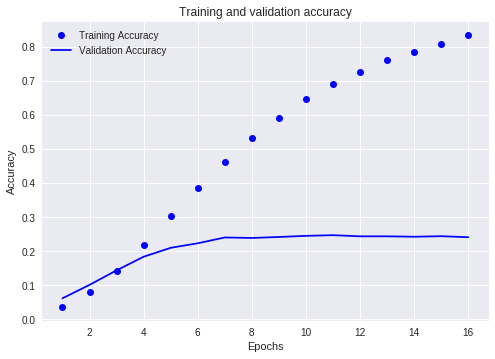

In [176]:
# plot test vs. train to show overfitting!

# Get loss function
acc = history1.history['acc']
val_acc = history1.history['val_acc']

# Setup grid for plotting
epochs =range(1, len(loss) + 1)
# Plot
plt.plot(epochs, acc, 'bo', label='Training Accuracy')
plt.plot(epochs, val_acc, 'b', label='Validation Accuracy')
plt.title('Training and validation accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.show()

In [0]:
# plot accuracy rates by author
from sklearn.metrics import classification_report, accuracy_score, confusion_matrix
import numpy as np

y_pred = model1.predict_classes(x_test)
# print(classification_report(y_test, y_pred))

cm = confusion_matrix(y_test, y_pred)
cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
accuracies = cm.diagonal()

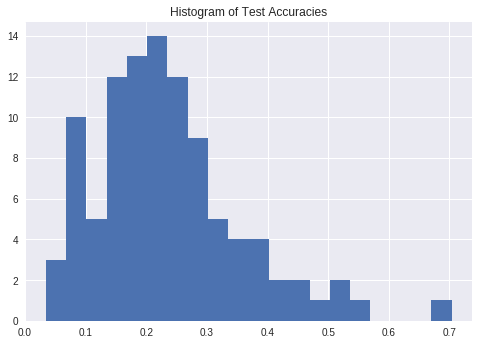

In [193]:
plt.hist(accuracies, bins=20)
plt.title('Histogram of Test Accuracy by Author')
plt.show()

In [215]:
# lots of politics, and very consistent writing style
print(accuracies.max())
print(accuracies.argmax())
print(df[['author', 'body']][df['author_id'] == 68][0:5])

0.7034482758620689
68
      author                                               body
9346  djphan  Kansas is an underrated pickup opportunity... ...
9347  djphan  how can i point to their argument without usin...
9348  djphan  i did.. i see the subsequent comments... and t...
9349  djphan  i literally quoted it in my first reply...  \n...
9350  djphan  youre saying that clinton did it herself... th...


In [186]:
# # keras.metrics.top_k_categorical_accuracy(y_test, predicted, k=5)
# from keras.metrics import top_k_categorical_accuracy
# keras.metrics.top_k_categorical_accuracy(y_test, y_pred, k=2)

#### Save Models

In [0]:
model1.save('model_l.h5')

#### EXTRA. Multilayer

In [0]:
# Multilayer LSTM
model5 = Sequential()
model5.add(Embedding(input_dim=max_features,
                    output_dim=128))

model5.add(CuDNNLSTM(128, return_sequences=True))
model5.add(Dropout(0.5))

model5.add(CuDNNLSTM(64))
model5.add(Dropout(0.5))

model5.add(Dense(100, activation="softmax"))

model5.compile(optimizer="adam", loss="sparse_categorical_crossentropy", metrics=["acc"])

In [68]:
history5 = model5.fit(x_train, y_train,
            batch_size=256,
            epochs=16,
            validation_data=(x_test, y_test))

Train on 58129 samples, validate on 14533 samples
Epoch 1/16
58129/58129 [==============================] - 46s 797us/step - loss: 4.4563 - acc: 0.0301 - val_loss: 4.2198 - val_acc: 0.0588
Epoch 2/16
58129/58129 [==============================] - 44s 764us/step - loss: 4.1062 - acc: 0.0710 - val_loss: 3.9898 - val_acc: 0.0962
Epoch 3/16
58129/58129 [==============================] - 44s 756us/step - loss: 3.8289 - acc: 0.1135 - val_loss: 3.7824 - val_acc: 0.1303
Epoch 4/16
58129/58129 [==============================] - 44s 765us/step - loss: 3.6063 - acc: 0.1513 - val_loss: 3.6834 - val_acc: 0.1494
Epoch 5/16
58129/58129 [==============================] - 44s 761us/step - loss: 3.4146 - acc: 0.1893 - val_loss: 3.6164 - val_acc: 0.1682
Epoch 6/16
58129/58129 [==============================] - 44s 753us/step - loss: 3.2467 - acc: 0.2262 - val_loss: 3.5665 - val_acc: 0.1844
Epoch 7/16
58129/58129 [==============================] - 44s 754us/step - loss: 3.0894 - acc: 0.2571 - val_loss: 3.

In [69]:
print('accuracy', model4.evaluate(x_test, y_test)[1])

14533/14533 [==============================] - 13s 883us/step
accuracy 0.22183995045860463
